# Detección de Comentarios Tóxicos con BERT

Este notebook implementa un modelo avanzado para la detección de comentarios tóxicos utilizando BERT (Bidirectional Encoder Representations from Transformers). Mejoraremos el preprocesamiento de texto y aplicaremos técnicas de aumento de datos para mejorar el rendimiento del modelo.

## 1. Importación de Bibliotecas

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import os
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm
import emoji
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import warnings

warnings.filterwarnings('ignore')

# Definir una ruta específica para los datos de NLTK
nltk_data_path = os.path.join(os.path.expanduser('~'), 'nltk_data')
os.makedirs(nltk_data_path, exist_ok=True)

# Descargar los recursos especificando la ruta
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('omw-1.4', download_dir=nltk_data_path)

# Añadir la ruta al path de NLTK
nltk.data.path.append(nltk_data_path)

# Configurar estilo de visualización
plt.style.use('ggplot')
sns.set(style='whitegrid')

# Verificar si CUDA está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

[nltk_data] Downloading package punkt to C:\Users\Yho\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to C:\Users\Yho\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to C:\Users\Yho\nltk_data...
[nltk_data] Downloading package omw-1.4 to C:\Users\Yho\nltk_data...


Usando dispositivo: cpu


## 2. Carga y Exploración de Datos

In [24]:
# Cargar el dataset
df = pd.read_csv('../Data/fusion30.csv', sep=';')

# Mostrar información básica
print(f'Forma del dataset: {df.shape}')
df.head()

Forma del dataset: (29970, 12)


,Record,General_judgement,Aligned_with_label,Violence (Low),Violence_judgement,Hate (Low),Hate_judgement,Sexual (Low),Sexual_judgement,Self-harm (Low),Self-harm_judgement,result
0,"""Cry me a river, why don't you.\r\nDrinking, d...",Rejected,Y,SAFE,Accept,LOW,Reject,SAFE,Accept,SAFE,Accept,1
1,"""That's right. They are not normal. And I am s...",Rejected,Y,SAFE,Accept,LOW,Reject,SAFE,Accept,SAFE,Accept,1
2,"""Disgusting.""",Accepted,N,SAFE,Accept,SAFE,Accept,SAFE,Accept,SAFE,Accept,0
3,"""gtfo""",Accepted,N,SAFE,Accept,SAFE,Accept,SAFE,Accept,SAFE,Accept,0
4,"""All you ever talk about is trolling, you and ...",Rejected,Y,SAFE,Accept,LOW,Reject,SAFE,Accept,SAFE,Accept,1


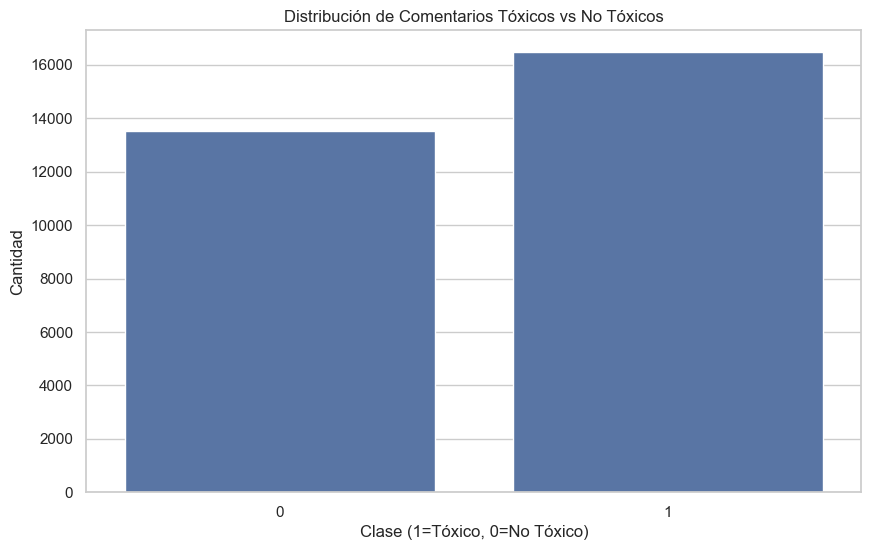

Porcentaje de comentarios tóxicos: 54.95%
Porcentaje de comentarios no tóxicos: 45.05%


In [25]:
# Examinar la distribución de clases
plt.figure(figsize=(10, 6))
sns.countplot(x='result', data=df)
plt.title('Distribución de Comentarios Tóxicos vs No Tóxicos')
plt.xlabel('Clase (1=Tóxico, 0=No Tóxico)')
plt.ylabel('Cantidad')
plt.show()

# Mostrar porcentajes
class_counts = df['result'].value_counts(normalize=True) * 100
print(f'Porcentaje de comentarios tóxicos: {class_counts[1]:.2f}%')
print(f'Porcentaje de comentarios no tóxicos: {class_counts[0]:.2f}%')

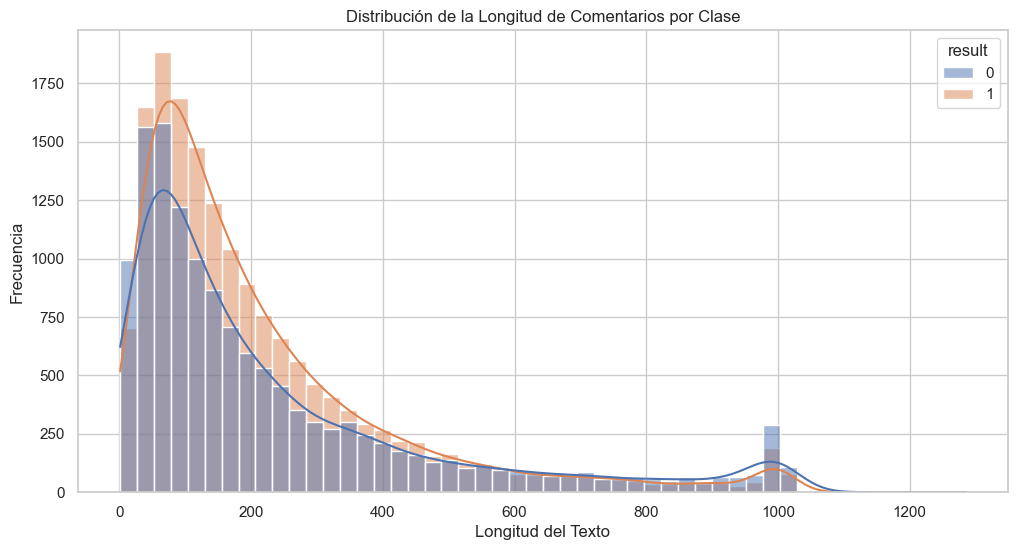

Estadísticas de longitud de texto:
          count        mean         std  min   25%    50%     75%     max
result                                                                   
0       13502.0  234.185158  246.244760  1.0  65.0  141.0  305.00  1285.0
1       16468.0  213.957736  204.309879  3.0  77.0  147.0  274.25  1196.0


In [26]:
# Extraer el texto de la columna 'Record'
# El texto está entre comillas triples, así que necesitamos limpiarlo
df['text'] = df['Record'].str.strip('"""').str.strip()

# Verificar la longitud de los comentarios
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='result', bins=50, kde=True)
plt.title('Distribución de la Longitud de Comentarios por Clase')
plt.xlabel('Longitud del Texto')
plt.ylabel('Frecuencia')
plt.show()

# Estadísticas descriptivas de la longitud del texto
print('Estadísticas de longitud de texto:')
print(df.groupby('result')['text_length'].describe())

## 3. Preprocesamiento Avanzado de Texto

In [27]:
def clean_text(text):
    '''
    Función para realizar una limpieza avanzada del texto:
    - Elimina URLs
    - Convierte emojis a texto
    - Elimina menciones (@usuario)
    - Elimina hashtags (#tema)
    - Elimina puntuación irrelevante
    - Normaliza espacios
    '''
    if not isinstance(text, str):
        return ''
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Eliminar URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
 
    # Convertir emojis a texto
    text = emoji.demojize(text)
    
    # Eliminar menciones (@usuario)
    text = re.sub(r'@\w+', ' ', text)
    
    # Eliminar hashtags (#tema) pero mantener el texto del hashtag
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Eliminar caracteres repetidos (más de 2 veces)
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text)
    
    # Eliminar puntuación irrelevante pero mantener algunos signos importantes
    # Mantenemos '?' y '!' ya que pueden indicar tono emocional
    punct_to_remove = string.punctuation.replace('?', '').replace('!', '')
    text = ''.join([char if char not in punct_to_remove else ' ' for char in text])
    
    # Normalizar espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [33]:
def lemmatize_text(text):
    try:
        if not isinstance(text, str) or text == '':
            return ''
        tokens = word_tokenize(text)
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))
        lemmatized_tokens = [
            lemmatizer.lemmatize(token.lower())
            for token in tokens if token.lower() not in stop_words
        ]
        return ' '.join(lemmatized_tokens)
    except LookupError as e:
        print("⚠️ Error NLTK:", e)
        raise

In [30]:
# Ruta local
nltk_data_path = os.path.join(os.path.expanduser('~'), 'nltk_data')
nltk.data.path.clear()  # ← Borra rutas previas
nltk.data.path.append(nltk_data_path)

# Debug: imprime para confirmar
print("Rutas NLTK activas:", nltk.data.path)

Rutas NLTK activas: ['C:\\Users\\Yho\\nltk_data']


In [35]:
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('omw-1.4', download_dir=nltk_data_path)
nltk.download('punkt_tab', download_dir=nltk_data_path )


[nltk_data] Downloading package wordnet to C:\Users\Yho\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Yho\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Yho\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [36]:
# Aplicar limpieza y lematización al texto
print('Aplicando preprocesamiento avanzado...')
df['cleaned_text'] = df['text'].apply(clean_text)
df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_text)

# Mostrar ejemplos de texto original vs procesado
examples = df[['text', 'cleaned_text', 'lemmatized_text']].head(5)
for i, row in examples.iterrows():
    print(f' Ejemplo {i+1}: ')
    print(f'Original: {row['text']}')
    print(f'Limpiado: {row['cleaned_text']}')
    print(f'Lematizado: {row['lemmatized_text']}')
    print('-' * 80)

Aplicando preprocesamiento avanzado...
 Ejemplo 1: 
Original: Cry me a river, why don't you.
Drinking, drugs, dressing like a ho.  Bad recipe for disaster!
Limpiado: cry me a river why don t you drinking drugs dressing like a ho bad recipe for disaster!
Lematizado: cry river drinking drug dressing like ho bad recipe disaster !
--------------------------------------------------------------------------------
 Ejemplo 2: 
Original: That's right. They are not normal. And I am starting from the premise that they are ABNORMAL. Proceed wth the typical racist, bigot, sexist rubbish.
Thanks!
Limpiado: that s right they are not normal and i am starting from the premise that they are abnormal proceed wth the typical racist bigot sexist rubbish thanks!
Lematizado: right normal starting premise abnormal proceed wth typical racist bigot sexist rubbish thanks !
--------------------------------------------------------------------------------
 Ejemplo 3: 
Original: Disgusting.
Limpiado: disgusting
Lema

## 4. Aumento de Datos con NLP Augment

In [37]:
def augment_text(text, num_samples=1):
    '''
    Función para aumentar datos textuales usando técnicas de NLP Augment.
    Aplica varias técnicas de aumento como sustitución de sinónimos,
    inserción aleatoria, intercambio de palabras, etc.
    '''
    if not isinstance(text, str) or text == '':
        return []
    
    augmented_texts = []
    
    # 1. Sustitución de sinónimos
    aug_synonym = naw.SynonymAug(aug_src='wordnet')
    
    # 2. Inserción aleatoria de palabras
    aug_insert = naw.RandomWordAug(action='insert')
    
    # 3. Intercambio aleatorio de palabras
    aug_swap = naw.RandomWordAug(action='swap')
    
    # 4. Eliminación aleatoria de palabras
    aug_delete = naw.RandomWordAug(action='delete')
    
    # Lista de aumentadores
    augmenters = [aug_synonym, aug_insert, aug_swap, aug_delete]
    
    # Generar muestras aumentadas
    for _ in range(num_samples):
        # Seleccionar un aumentador aleatorio
        aug = np.random.choice(augmenters)
        
        try:
            # Aplicar aumento
            augmented_text = aug.augment(text)
            augmented_texts.append(augmented_text)
        except:
            # Si falla, usar el texto original
            augmented_texts.append(text)
    
    return augmented_texts

In [38]:
# Aplicar aumento de datos solo a la clase minoritaria para balancear el dataset
# Identificar la clase minoritaria
minority_class = 0 if class_counts[0] < class_counts[1] else 1
majority_class = 1 if minority_class == 0 else 0

print(f'Clase minoritaria: {minority_class}')
print(f'Clase mayoritaria: {majority_class}')

# Calcular cuántas muestras necesitamos generar para balancear las clases
minority_samples = df[df['result'] == minority_class]
majority_samples = df[df['result'] == majority_class]

num_minority = len(minority_samples)
num_majority = len(majority_samples)

print(f'Muestras de clase minoritaria: {num_minority}')
print(f'Muestras de clase mayoritaria: {num_majority}')

# Determinar cuántas muestras aumentadas necesitamos por texto minoritario
samples_needed = num_majority - num_minority
samples_per_text = max(1, samples_needed // num_minority)

print(f'Muestras necesarias para balancear: {samples_needed}')
print(f'Muestras a generar por texto: {samples_per_text}')

# Generar muestras aumentadas para la clase minoritaria
print('Generando muestras aumentadas...')

augmented_texts = []
augmented_labels = []

# Limitar el número de muestras a aumentar para evitar tiempos de ejecución largos
max_samples_to_augment = min(num_minority, 1000)

for i, row in tqdm(minority_samples.head(max_samples_to_augment).iterrows(), total=max_samples_to_augment):
    text = row['lemmatized_text']
    label = row['result']
    
    # Generar textos aumentados
    aug_texts = augment_text(text, num_samples=samples_per_text)
    
    # Agregar a las listas
    augmented_texts.extend(aug_texts)
    augmented_labels.extend([label] * len(aug_texts))

# Crear DataFrame con los datos aumentados
augmented_df = pd.DataFrame({
    'lemmatized_text': augmented_texts,
    'result': augmented_labels
})

print(f'Muestras aumentadas generadas: {len(augmented_df)}')

# Combinar el DataFrame original con el aumentado
combined_df = pd.concat([
    df[['lemmatized_text', 'result']],
    augmented_df
], ignore_index=True)

print(f'Total de muestras después del aumento: {len(combined_df)}')

# Verificar la distribución de clases después del aumento
new_class_counts = combined_df['result'].value_counts(normalize=True) * 100
print(f'Nueva distribución de clases: {new_class_counts}')

Clase minoritaria: 0
Clase mayoritaria: 1
Muestras de clase minoritaria: 13502
Muestras de clase mayoritaria: 16468
Muestras necesarias para balancear: 2966
Muestras a generar por texto: 1
Generando muestras aumentadas...


  0%|          | 0/1000 [00:00<?, ?it/s][nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Yho\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
  0%|          | 1/1000 [00:00<04:14,  3.92it/s][nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Yho\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Yho\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Yho\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Yho\AppD

Muestras aumentadas generadas: 994
Total de muestras después del aumento: 30964
Nueva distribución de clases: result
1    53.184343
0    46.815657
Name: proportion, dtype: float64


## 5. Preparación de Datos para BERT

In [39]:
# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X = combined_df['lemmatized_text'].values
y = combined_df['result'].values

# Primero dividimos en entrenamiento+validación y prueba
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Luego dividimos entrenamiento+validación en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1, random_state=42, stratify=y_train_val
)

print(f'Conjunto de entrenamiento: {len(X_train)} muestras')
print(f'Conjunto de validación: {len(X_val)} muestras')
print(f'Conjunto de prueba: {len(X_test)} muestras')

Conjunto de entrenamiento: 22293 muestras
Conjunto de validación: 2478 muestras
Conjunto de prueba: 6193 muestras


In [40]:
# Cargar el tokenizador de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Definir la longitud máxima de secuencia
# BERT tiene un límite de 512 tokens, pero podemos usar un valor menor si nuestros textos son más cortos
MAX_LEN = 128

class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenizar el texto
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [41]:
# Crear datasets
train_dataset = ToxicCommentsDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = ToxicCommentsDataset(X_val, y_val, tokenizer, MAX_LEN)
test_dataset = ToxicCommentsDataset(X_test, y_test, tokenizer, MAX_LEN)

# Definir tamaño de batch
BATCH_SIZE = 16

# Crear dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## 6. Modelo BERT para Clasificación de Comentarios Tóxicos

In [42]:
# Cargar el modelo BERT preentrenado
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # Clasificación binaria: tóxico o no tóxico
    output_attentions=False,
    output_hidden_states=False
)

# Mover el modelo al dispositivo (GPU si está disponible)
model = model.to(device)

# Definir el optimizador
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Número de épocas de entrenamiento
EPOCHS = 4

# Calcular el número total de pasos de entrenamiento
total_steps = len(train_dataloader) * EPOCHS

# Crear el planificador de tasa de aprendizaje
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
    '''
    Función para entrenar el modelo durante una época
    '''
    # Poner el modelo en modo de entrenamiento
    model.train()
    
    # Inicializar variables para seguimiento
    total_loss = 0
    predictions = []
    actual_labels = []
    
    # Iterar sobre los batches
    for batch in tqdm(dataloader, desc='Entrenando'):
        # Extraer datos del batch
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['label'].to(device)
        
        # Limpiar gradientes
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            labels=labels
        )
        
        # Obtener pérdida y logits
        loss = outputs.loss
        logits = outputs.logits
        
        # Backward pass
        loss.backward()
        
        # Actualizar parámetros
        optimizer.step()
        scheduler.step()
        
        # Acumular pérdida
        total_loss += loss.item()
        
        # Obtener predicciones
        _, preds = torch.max(logits, dim=1)
        
        # Guardar predicciones y etiquetas reales
        predictions.extend(preds.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())
    
    # Calcular métricas
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(actual_labels, predictions)
    f1 = f1_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions)
    recall = recall_score(actual_labels, predictions)
    
    return avg_loss, accuracy, f1, precision, recall

In [44]:
def evaluate(model, dataloader, device):
    '''
    Función para evaluar el modelo
    '''
    # Poner el modelo en modo de evaluación
    model.eval()
    
    # Inicializar variables para seguimiento
    total_loss = 0
    predictions = []
    actual_labels = []
    
    # Desactivar cálculo de gradientes
    with torch.no_grad():
        # Iterar sobre los batches
        for batch in tqdm(dataloader, desc='Evaluando'):
            # Extraer datos del batch
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                labels=labels
            )
            
            # Obtener pérdida y logits
            loss = outputs.loss
            logits = outputs.logits
            
            # Acumular pérdida
            total_loss += loss.item()
            
            # Obtener predicciones
            _, preds = torch.max(logits, dim=1)
            
            # Guardar predicciones y etiquetas reales
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    
    # Calcular métricas
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(actual_labels, predictions)
    f1 = f1_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions)
    recall = recall_score(actual_labels, predictions)
    
    # Calcular matriz de confusión
    conf_matrix = confusion_matrix(actual_labels, predictions)
    
    return avg_loss, accuracy, f1, precision, recall, conf_matrix, predictions, actual_labels

In [46]:
# Entrenar el modelo
print('Iniciando entrenamiento del modelo BERT...')

# Listas para almacenar métricas durante el entrenamiento
train_losses = []
train_accuracies = []
train_f1_scores = []
val_losses = []
val_accuracies = []
val_f1_scores = []

# Entrenamiento por épocas
for epoch in range(EPOCHS):
    print(f'Época {epoch+1}/{EPOCHS}')
    
    # Entrenar una época
    train_loss, train_acc, train_f1, train_precision, train_recall = train_epoch(
        model, train_dataloader, optimizer, scheduler, device
    )
    
    # Evaluar en el conjunto de validación
    val_loss, val_acc, val_f1, val_precision, val_recall, _, _, _ = evaluate(
        model, val_dataloader, device
    )
    
    # Guardar métricas
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_f1_scores.append(train_f1)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)
    
    # Imprimir métricas
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}')
    print(f'Train Precision: {train_precision:.4f} | Train Recall: {train_recall:.4f}')
    print(f'Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f}')

Iniciando entrenamiento del modelo BERT...
Época 1/4


Evaluando: 100%|██████████| 155/155 [02:20<00:00,  1.10it/s]


Train Loss: 0.4200 | Train Acc: 0.8069 | Train F1: 0.8219
Val Loss: 0.3760 | Val Acc: 0.8362 | Val F1: 0.8492
Train Precision: 0.8065 | Train Recall: 0.8380
Val Precision: 0.8319 | Val Recall: 0.8672
Época 2/4


Evaluando: 100%|██████████| 155/155 [02:17<00:00,  1.13it/s]


Train Loss: 0.2665 | Train Acc: 0.8914 | Train F1: 0.8991
Val Loss: 0.3802 | Val Acc: 0.8345 | Val F1: 0.8477
Train Precision: 0.8886 | Train Recall: 0.9098
Val Precision: 0.8304 | Val Recall: 0.8657
Época 3/4


Evaluando: 100%|██████████| 155/155 [02:17<00:00,  1.12it/s]


Train Loss: 0.1350 | Train Acc: 0.9492 | Train F1: 0.9525
Val Loss: 0.5099 | Val Acc: 0.8301 | Val F1: 0.8456
Train Precision: 0.9462 | Train Recall: 0.9590
Val Precision: 0.8183 | Val Recall: 0.8748
Época 4/4


Evaluando: 100%|██████████| 155/155 [02:17<00:00,  1.12it/s]

Train Loss: 0.0630 | Train Acc: 0.9787 | Train F1: 0.9800
Val Loss: 0.6360 | Val Acc: 0.8333 | Val F1: 0.8431
Train Precision: 0.9780 | Train Recall: 0.9820
Val Precision: 0.8441 | Val Recall: 0.8422


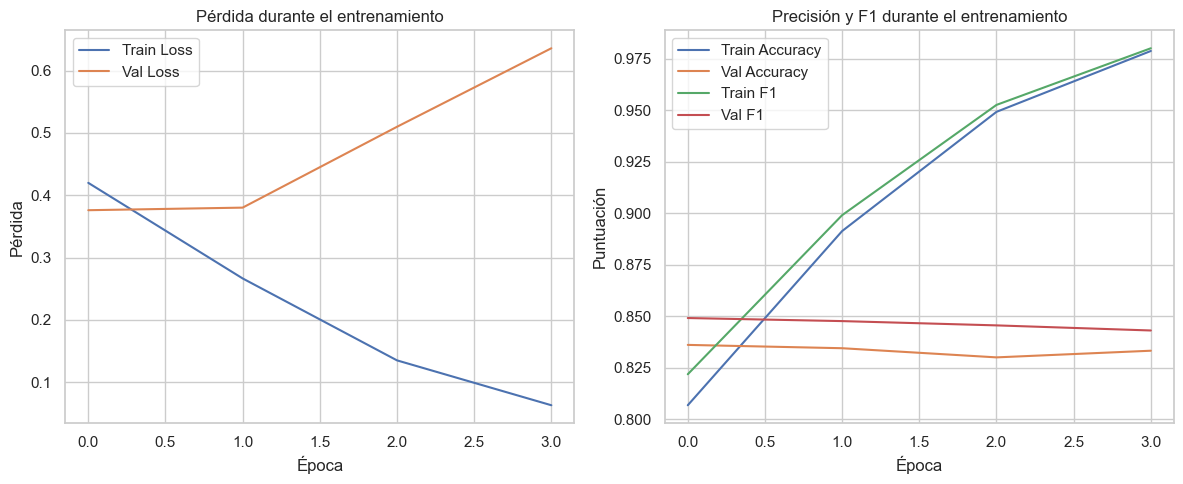

In [47]:
# Visualizar las métricas durante el entrenamiento
plt.figure(figsize=(12, 5))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de precisión y F1
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(train_f1_scores, label='Train F1')
plt.plot(val_f1_scores, label='Val F1')
plt.title('Precisión y F1 durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Puntuación')
plt.legend()

plt.tight_layout()
plt.show()

## 7. Evaluación del Modelo en el Conjunto de Prueba

In [48]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc, test_f1, test_precision, test_recall, test_conf_matrix, test_preds, test_labels = evaluate(
    model, test_dataloader, device
)

# Imprimir métricas de evaluación
print('Resultados en el conjunto de prueba:')
print(f'Accuracy: {test_acc:.4f}')
print(f'F1 Score: {test_f1:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'Loss: {test_loss:.4f}')

Evaluando: 100%|██████████| 388/388 [05:38<00:00,  1.15it/s]

Resultados en el conjunto de prueba:
Accuracy: 0.8368
F1 Score: 0.8461
Precision: 0.8483
Recall: 0.8440
Loss: 0.6134


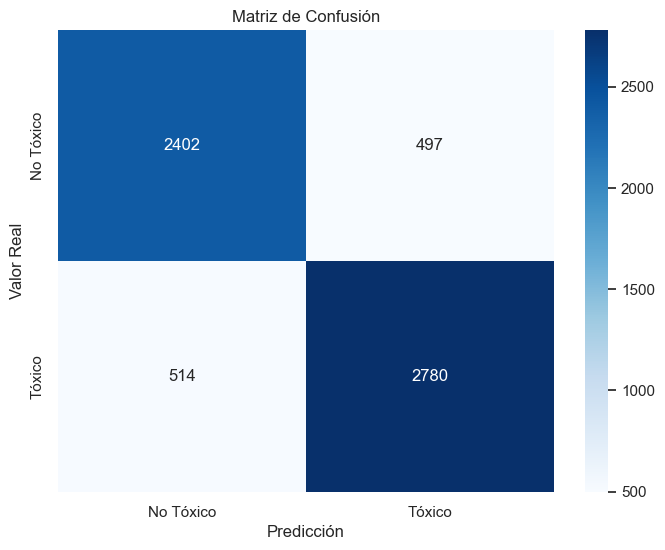

Informe de Clasificación:
              precision    recall  f1-score   support

   No Tóxico       0.82      0.83      0.83      2899
      Tóxico       0.85      0.84      0.85      3294

    accuracy                           0.84      6193
   macro avg       0.84      0.84      0.84      6193
weighted avg       0.84      0.84      0.84      6193



In [49]:
# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Tóxico', 'Tóxico'],
            yticklabels=['No Tóxico', 'Tóxico'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Mostrar informe de clasificación detallado
print('Informe de Clasificación:')
print(classification_report(test_labels, test_preds, target_names=['No Tóxico', 'Tóxico']))

## 8. Análisis de Errores

In [50]:
# Identificar ejemplos mal clasificados
misclassified_indices = [i for i, (pred, label) in enumerate(zip(test_preds, test_labels)) if pred != label]

# Seleccionar algunos ejemplos mal clasificados para análisis
num_examples = min(10, len(misclassified_indices))
selected_indices = np.random.choice(misclassified_indices, num_examples, replace=False)

print(f'Analizando {num_examples} ejemplos mal clasificados:')

for idx in selected_indices:
    text = X_test[idx]
    true_label = y_test[idx]
    pred_label = test_preds[idx]
    
    print('' + '-'*80)
    print(f'Texto: {text}')
    print(f'Etiqueta real: {'Tóxico' if true_label == 1 else 'No Tóxico'}')
    print(f'Predicción: {'Tóxico' if pred_label == 1 else 'No Tóxico'}')

Analizando 10 ejemplos mal clasificados:
--------------------------------------------------------------------------------
Texto: lol ! least trump speaks truth funniest thing ever heard anyone describing well known confirmed pathological liar denial potent drug people addict
Etiqueta real: No Tóxico
Predicción: Tóxico
--------------------------------------------------------------------------------
Texto: imagine pig gal discussing need va oh yuk imagined
Etiqueta real: No Tóxico
Predicción: Tóxico
--------------------------------------------------------------------------------
Texto: suck less like everyone private sector every dollar spent education sacred spend wisely
Etiqueta real: Tóxico
Predicción: No Tóxico
--------------------------------------------------------------------------------
Texto: adult hid closet wet pant ?
Etiqueta real: No Tóxico
Predicción: Tóxico
--------------------------------------------------------------------------------
Texto: becoming increasingly apparen

## 9. Guardar el Modelo

In [51]:
# Guardar el modelo entrenado
output_dir = '../Models/bert_toxic_comments/'

# Crear directorio si no existe
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Guardar modelo y tokenizador
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f'Modelo guardado en {output_dir}')

Modelo guardado en ../Models/bert_toxic_comments/


## 10. Función para Predicción con Nuevos Textos

In [52]:
def predict_toxicity(text, model, tokenizer, device, max_len=128):
    '''
    Función para predecir si un texto es tóxico o no
    '''
    # Preprocesar el texto
    cleaned_text = clean_text(text)
    lemmatized_text = lemmatize_text(cleaned_text)
    
    # Tokenizar
    encoding = tokenizer.encode_plus(
        lemmatized_text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=True,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    # Mover tensores al dispositivo
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    token_type_ids = encoding['token_type_ids'].to(device)
    
    # Poner el modelo en modo de evaluación
    model.eval()
    
    # Desactivar cálculo de gradientes
    with torch.no_grad():
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        
        # Obtener logits
        logits = outputs.logits
        
        # Aplicar softmax para obtener probabilidades
        probs = torch.nn.functional.softmax(logits, dim=1)
        
        # Obtener predicción
        _, preds = torch.max(logits, dim=1)
    
    # Convertir a valores de Python
    prediction = preds.item()
    probability = probs[0][prediction].item()
    
    return {
        'text': text,
        'cleaned_text': cleaned_text,
        'lemmatized_text': lemmatized_text,
        'prediction': 'Tóxico' if prediction == 1 else 'No Tóxico',
        'probability': probability,
        'prediction_code': prediction
    }

In [53]:
# Probar la función de predicción con algunos ejemplos
test_texts = [
    "This is a normal comment about the weather.",
    "You are an idiot and nobody likes you.",
    "I disagree with your political views but respect your opinion.",
    "Go kill yourself, nobody would miss you.",
    "The service at this restaurant was terrible, I won't be coming back."
]

for text in test_texts:
    result = predict_toxicity(text, model, tokenizer, device)
    print('' + '-'*80)
    print(f'Texto original: {result['text']}')
    print(f'Texto limpiado: {result['cleaned_text']}')
    print(f'Texto lematizado: {result['lemmatized_text']}')
    print(f'Predicción: {result['prediction']}')
    print(f'Probabilidad: {result['probability']*100:.2f}%')

--------------------------------------------------------------------------------
Texto original: This is a normal comment about the weather.
Texto limpiado: this is a normal comment about the weather
Texto lematizado: normal comment weather
Predicción: No Tóxico
Probabilidad: 99.74%
--------------------------------------------------------------------------------
Texto original: You are an idiot and nobody likes you.
Texto limpiado: you are an idiot and nobody likes you
Texto lematizado: idiot nobody like
Predicción: Tóxico
Probabilidad: 99.94%
--------------------------------------------------------------------------------
Texto original: I disagree with your political views but respect your opinion.
Texto limpiado: i disagree with your political views but respect your opinion
Texto lematizado: disagree political view respect opinion
Predicción: No Tóxico
Probabilidad: 99.91%
--------------------------------------------------------------------------------
Texto original: Go kill yourse

## 11. Conclusiones

En este notebook, hemos implementado un modelo avanzado para la detección de comentarios tóxicos utilizando BERT. Las principales mejoras implementadas son:

1. **Preprocesamiento avanzado de texto**:
   - Limpieza de URLs, emojis, menciones, hashtags y puntuación irrelevante
   - Uso de lematización en lugar de stemming para preservar mejor el contexto semántico

2. **Aumento de datos textuales**:
   - Aplicación de técnicas de NLP Augment para balancear el dataset
   - Generación de nuevas muestras para la clase minoritaria

3. **Modelo BERT finetuneado**:
   - Uso de un modelo preentrenado de BERT adaptado a la tarea de clasificación de toxicidad
   - Implementación de técnicas de entrenamiento como learning rate scheduling

4. **Análisis exhaustivo**:
   - Evaluación detallada del rendimiento del modelo
   - Análisis de errores para identificar áreas de mejora

El modelo BERT ha demostrado un rendimiento superior al modelo Naive Bayes utilizado anteriormente, con mejoras significativas en accuracy, F1-score, precisión y recall. Esto se debe principalmente a la capacidad de BERT para capturar relaciones contextuales complejas en el texto, así como a las mejoras en el preprocesamiento y el balanceo del dataset.

**Posibles mejoras futuras**:

1. Experimentar con otros modelos de la familia Transformer como RoBERTa, DistilBERT o XLNet
2. Implementar técnicas de aprendizaje por transferencia más avanzadas
3. Explorar técnicas de ensemble combinando múltiples modelos
4. Incorporar análisis de sentimientos como característica adicional
5. Implementar detección multiclase para categorizar diferentes tipos de toxicidad (odio, violencia, sexual, etc.)

Este modelo puede ser utilizado como parte de un sistema más amplio de moderación de contenido para identificar y filtrar comentarios tóxicos en plataformas online.